# <b>Overview:</b>

Structured data, defined as data following a fixed pattern such as information stored in columns within databases, and unstructured data, which lacks a specific form or pattern like text, images, or social media posts, both continue to grow as they are produced and consumed by various organizations. For instance, according to International Data Corporation (IDC), the world’s data volume is expected to increase tenfold by 2025, with unstructured data accounting for a significant portion. Enterprises may want to add custom metadata like document types, various entity types in addition to the standard metadata like file type, date created, size etc. to extend the intelligent search while ingesting the documents. The custom metadata helps organizations and enterprises categorize information in their preferred way for example metadata can be used for filtering, searching etc. Customers can create the custom metadata using [Amazon Comprehend](https://aws.amazon.com/comprehend/) and ingest it into [Amazon Kendra](https://aws.amazon.com/kendra/) along with their data into the index. The custom metadata then can be leveraged to enrich the content for better [filtering and facet](https://docs.aws.amazon.com/kendra/latest/dg/filtering.html) capabilities, for an experience similar to the [Amazon.com](http://amazon.com/) retail site where you’re presented with filtering options on the left side of the webpage. But what if the original documents have no metadata/attributes, or users have a preference for how this  is categorized? You can automatically enrich the content and make it easier to search and discover using this lab.

For this lab we use sample insurance documents coming from various law firms and insurance company needs to search/process the documents in efficiently. We ingest these documents and automatically generate content/docuement metadata and attributes using Amazon Kendra CDE custom logic with Amazon Comprehend APIs, into a unified Amazon Kendra index to make it searchable. Finally we use the Amazon Kendra search page to show how the metadata and attributes enhanced the search capability by adding faceting and filtering capability.

<b>Architecture Diagram:</b>

<br />
<br />

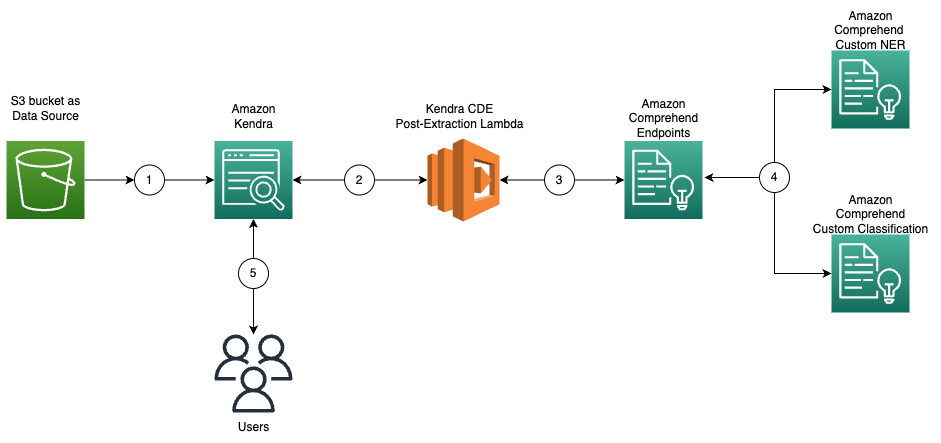


You will perform the following steps in this notebook:

1. Setup prerequisites.
2. Copy the text to an Amazon S3 bucket that is configured as a data source to the Amazon Kendra index using the S3 connector.
3. Ingest the text data to the Amazon Kendra Index.
4. Upload training data and build custom classifier as well as custom entity recognizer models using Amazon Comprehend.
5. Use Kendra - Custom Document Enrichment (CDE) post-extraction lambda to call Amazon Comprehend endpoints hosting custom classifier as well as custom entity recognizer models.
6. Amazon Comprehend identifies top entities of types "Law Firm", "Insurance Company", "Payout", "Policy Number", "Policy Holder Name". Additionally, we also get one of the following classes for an input document returned by the custom classifier - Auto_Insurance, Home_Insurance, Life_Insurance. 
7. Run search queries in Amazon Kendra, using the extracted metadata from Amazon Comprehend to filter and facet the search results.


## Outline

1. [Prerequisites and setup](#step1)
    1. [Install dependencies](#step1_1)
    2. [S3 setup](#step1_2)
    3. [Set up IAM permissions](#step1_3)
2. [Train the model for custom classifier](#step2)
    1. [Start Training with the Dataset](#step2_1)
    2. [Create endpoint and run inference](#step2_2)
3. [Train the model for custom entity recognition](#step3)
    1. [Start Training with the datset](#step3_1)
    2. [Create endpoint and run inference](#step3_2)
4. [Create Lambda function for post extraction enrichment](#step4)
    1. [Define Lambda function](#step4_1)
    2. [Deploy Lambda function](#step4_2)
5. [Create a Kendra index](#step5)
    1. [Create index](#step5_1)
    2. [Using an S3 data source for the Kendra index](#step5_2)
    3. [Populate the Kendra index](#step5_3)
6. [Use the extracted entities to filter searches in Kendra](#step6)
    1. [Try a query](#step6_1)
7. [Clean up](#step7)
8. [Conclusion](#step8)


## 1. Prerequisites and setup <a id="step1"></a>

This lab requires AWS Admin/Sagemaker role and policies that grant permission for:

* S3 bucket create/delete/get/put
* IAM getRole/createRole/passRole
* Comprehend detect_entities, classify_document
* Lambda create
* and, Kendra full access



### 1.1. Load required libraries <a id="step1_1"></a>

In [ ]:
import sagemaker
import boto3
from datetime import datetime
from botocore.exceptions import ClientError
import pprint
import time
import json
import os

In [ ]:
# extract AWS region and IAM role information
region = boto3.Session().region_name    
session = sagemaker.Session()
sagemaker_role = sagemaker.get_execution_role()
account_id =  boto3.client('sts').get_caller_identity()['Account']
sagemaker_role_name = sagemaker_role[sagemaker_role.index("/")+1:]

In [ ]:
# check the role, account, and region
print(sagemaker_role)
print(account_id)
print(region)

### 1.2. S3 - create bucket and upload training, index data

For this lab, we are going to use the same S3 bucket for <br />
<br /> 1. Kendra data source 
<br /> 2. Kendra post extraction metadata
<br /> 3. source for lambda code
<br /> <br />
However, separate S3 bucket can be created and used as per the use case.

In [ ]:
# specify S3 bucket name here to use as a Kendra data source.
bucket_name = "comprehendlab-" + str(int(datetime.now().replace(microsecond=0).timestamp()))
bucket_name

In [ ]:
# create a prefix/key for copying the content from local folder ‘Data’ to S3 bucket we created earlier.
prefix_index = 'Data/Index_Data/'
prefix_lambda = 'Data/Lambda/'
prefix_training = 'Data/Training/'
data_folder = 'Index_Data'

In [ ]:
# let's create S3 client for the S3 bucket operations
s3_client = boto3.client('s3')
s3_client.create_bucket(Bucket=bucket_name)

In [ ]:
# copy index data to the S3 bucket prefix created above
local_dir = './Data/Insurance_Data'
for file in [f for f in os.listdir(local_dir) if not f.startswith('.')]:
    s3_client.upload_file(f'{local_dir}/{file}', bucket_name, f'{prefix_index}{file}')

In [ ]:
# copy training data to the S3 bucket prefix created above
local_dir = './Data/Training_Data'
for file in [f for f in os.listdir(local_dir) if not f.startswith('.')]:
    s3_client.upload_file(f'{local_dir}/{file}', bucket_name, f'{prefix_training}{file}')

### 1.3. Set up IAM permissions <a id="step1_3"></a>
***
To use the Amazon Comprehend Custom Classification and Custom Entity Recognizer APIs, we need to attach <b>ComprehendFullAccess</b> and <b>AmazonS3FullAccess</b> policies to the IAM role associated with the Sagemaker Notebook instance. These policies provides full access to Amazon Comprehend Custom Classifier and to Amazon S3. 

**Note:** For a production application, we recommend that you restrict access policies to only those needed to run the application. Permissions can be restricted based on the use case (training/inference) and specific resource names (such as a full S3 bucket name or an S3 bucket name pattern). You should also restrict access to the Custom Classifier or Amazon Sagemaker operations to just those that your application needs. 
***
We will create following roles:
<br />
1. KendraDSRole: the role needed to attach the S3 Data Source <br />
2. KendraIndexRole: the role needed to create a Kendra Index <br />
3. KendraLambdaRole: the role assigned to the lambda function that is invoked as part of Custom Document Enrichment <br />

In [ ]:
# Create IAM client for creating roles, trust relationships, and associated policieis
iam = boto3.client('iam')
kendra_data_source_role = 'KendraDSRole'
kendra_index_role = 'KendraIndexRole'
kendra_lambda_role = 'KendraLambdaRole'

### 1.3.1 Let's start by creating the role to be used for creating the Kendra index

In [ ]:
# this is the trust relationship that Kendra index and Kendra data source roles will have with the Kendra service
trust_relationship_policy_kendra_service = json.dumps({
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Principal": {
                    "Service":"kendra.amazonaws.com"
                },
            "Action": "sts:AssumeRole"
        }
    ]
})

In [ ]:
# create the role with the above trust policy
kendra_index_role_response = iam.create_role(
        RoleName=kendra_index_role,
        AssumeRolePolicyDocument=trust_relationship_policy_kendra_service,
        Description='This role is used to create Kendra Index'
)

In [ ]:
# Define and create a policy for KendraIndexRole
kendra_index_policy = json.dumps({
    "Version": "2012-10-17",
    "Statement": [
        {
            "Condition": {
                "StringEquals": {
                    "cloudwatch:namespace": "Kendra"
                }
            },
            "Action": [
                "cloudwatch:PutMetricData"
            ],
            "Resource": "*",
            "Effect": "Allow"
        },
        {
            "Action": "logs:DescribeLogGroups",
            "Resource": "*",
            "Effect": "Allow"
        },
        {
            "Action": "logs:CreateLogGroup",
            "Resource": f"arn:aws:logs:{region}:{account_id}:log-group:/aws/kendra/*",
            "Effect": "Allow"
        },
        {
            "Action": [
                "logs:DescribeLogStreams",
                "logs:CreateLogStream",
                "logs:PutLogEvents"
            ],
            "Resource": f"arn:aws:logs:{region}:{account_id}:log-group:/aws/kendra/*:log-stream:*",
            "Effect": "Allow"
        }
    ]
})

# create the policy
response = iam.create_policy(
  PolicyName='KendraL8CIndexPolicy',
  PolicyDocument=kendra_index_policy
)

In [ ]:
# now attach the policy with the Kendra index role
response = iam.attach_role_policy(
    RoleName=kendra_index_role,
    PolicyArn=f"arn:aws:iam::{account_id}:policy/KendraL8CIndexPolicy"
)

### 1.3.2 Create role for Kendra Data Source
<br /> We will attach the required least privilege policy <u>after</u> Kendra Index is created since Kendra Data Source policy refers to Kendra Index Id.

In [ ]:
# create Kendra data source role
kendra_ds_role_response = iam.create_role(
        RoleName=kendra_data_source_role,
        AssumeRolePolicyDocument=trust_relationship_policy_kendra_service,
        Description='This role is used to create Kendra S3 data source'
)

### 1.3.3 Create role for Lambda function
<br /> We will attach the policy after Kendra Index is created since Kendra Data Source policy refers to Kendra Index Id.

In [ ]:
# create trust policy for lambda service
trust_relationship_policy_lambda_service = json.dumps({
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Principal": {
                    "Service":"lambda.amazonaws.com"
                },
            "Action": "sts:AssumeRole"
        }
    ]
})

In [ ]:
# create lambda role
kendra_lambda_role_response = iam.create_role(
        RoleName=kendra_lambda_role,
        AssumeRolePolicyDocument=trust_relationship_policy_lambda_service,
        Description='This role is used to create post extract Lambda function'
)
kendra_lambda_role_response

In [ ]:
# Create a policy for Lambda role
kendra_lambda_policy = json.dumps({
    "Version": "2012-10-17",
    "Statement": [
        {
            "Action": [
                "s3:GetObject",
                "s3:PutObject"
            ],
            "Resource": f"arn:aws:s3:::{bucket_name}/*",
            "Effect": "Allow"
        },
        {
            "Action": "s3:ListBucket",
            "Resource": f"arn:aws:s3:::{bucket_name}",
            "Effect": "Allow"
        },
        {
            "Action": "lambda:InvokeFunction",
            "Resource": f"arn:aws:lambda:{region}:{account_id}:function:kendra-cde-postextraction-lambda*",
            "Effect": "Allow"
        },
        {
            "Action": [
                "logs:CreateLogGroup",
                "logs:CreateLogStream",
                "logs:PutLogEvents"
            ],
            "Resource": "*",
            "Effect": "Allow"
        },
        {
            "Action": [
                "comprehend:DetectEntities",
                "comprehend:ClassifyDocument"
            ],
            "Resource": "*",
            "Effect": "Allow"
        }
    ]
})

response = iam.create_policy(
  PolicyName='KendraL8CLambdaPolicy',
  PolicyDocument=kendra_lambda_policy
)

In [ ]:
# attach least privilege policy to the role
response = iam.attach_role_policy(
    RoleName=kendra_lambda_role,
    PolicyArn=f"arn:aws:iam::{account_id}:policy/KendraL8CLambdaPolicy"
)
response

In [ ]:
# Create a policy for SageMaker role to write output to the S3 bucket
sagemaker_s3_policy = json.dumps({
    "Version": "2012-10-17",
    "Statement": [
        {
            "Action": [
                "s3:*"
            ],
            "Resource": f"arn:aws:s3:::{bucket_name}/*",
            "Effect": "Allow"
        }
    ]
})

response = iam.create_policy(
  PolicyName='SageMakerS3Policy',
  PolicyDocument=sagemaker_s3_policy
)

In [ ]:
response = iam.get_role(RoleName=sagemaker_role_name) 

trust_policy = response['Role']['AssumeRolePolicyDocument']

In [ ]:
trust_policy['Statement'].append({'Effect': 'Allow',
   'Principal': {'Service': 'comprehend.amazonaws.com'},
   'Action': 'sts:AssumeRole'})

trust_policy['Statement'].append({'Effect': 'Allow',
   'Principal': {'Service': 's3.amazonaws.com'},
   'Action': 'sts:AssumeRole'})

In [ ]:
response = iam.update_assume_role_policy(
    RoleName=sagemaker_role_name,
    PolicyDocument=json.dumps(trust_policy)
)
response

In [ ]:
# attach least privilege policy to the role
response = iam.attach_role_policy(
    RoleName=sagemaker_role_name,
    PolicyArn=f"arn:aws:iam::{account_id}:policy/SageMakerS3Policy"
)
response

## 2. Train the model for custom classifier <a id="step2"></a>
**Important** You are charged for the amount of time it takes to successfully train a model.

***

### 2.1. Training <a id="step2_1"></a>
***
Train your custom classifier model in either multi-class or multi-label mode. The concept of class is used for both modes. It's a custom category that applies to the document being analyzed. However, each mode uses class differently. Multi-class mode associates only a single class with each document. Multi-label mode associates more than one class with a document

In this case, we will be training a Multi Class Classifier
***


#### 2.1.1.  Start Training Job

You can prepare separate training and testing datasets for Comprehend custom classifier training and model evaluation. Or only provide one dataset for both training and testing. Comprehend will automatically select 10% of your provided dataset to use as testing data. In the below example, we specified the training dataset as *S3Uri* under *InputDataConfig*. 

In [ ]:
import uuid
compre_client = boto3.client('comprehend', region_name=region)

train_data_s3uri = f's3://{bucket_name}/{prefix_training}comprehend_kendra_workshop_raw_data.csv'
train_output_s3uri = f's3://{bucket_name}/{prefix_training}'

document_classifier_name = 'l8c-classifier-' + str(uuid.uuid4())[0:5]
document_classifier_arn = ''
response = None

response = compre_client.create_document_classifier(
    DocumentClassifierName=document_classifier_name,
    DataAccessRoleArn=sagemaker_role,
    InputDataConfig={
        'DataFormat': 'COMPREHEND_CSV',
        'S3Uri': train_data_s3uri,
    },
    OutputDataConfig={
        'S3Uri': train_output_s3uri
    },
    LanguageCode='en'
)
document_classifier_arn = response['DocumentClassifierArn']
    
print('Document Classifier ARN: ' + document_classifier_arn)
print(response)

#### 2.1.2. Check Status of the Training Job
After you create a custom classifier, you can monitor the progress of the request using the DescribeDocumentClassifier operation. Once the Status field is TRAINED you can then use the classifier to classify documents.

In [ ]:
from datetime import timezone

response = None
repeat = True
status = ''
submit_datetime = None
end_datetime = None
output_data_config_s3uri = ''

while True:
    response = compre_client.describe_document_classifier(
        DocumentClassifierArn=document_classifier_arn
    )
    status = response['DocumentClassifierProperties']['Status']
    submit_datetime = response['DocumentClassifierProperties']['SubmitTime']
        
    if status in ['SUBMITTED', 'TRAINING', 'DELETING', 'STOP_REQUESTED']: # status is going to change
        end_datetime = datetime.now(timezone.utc)
        if repeat:
            print('.', end = '')
            time.sleep(20)
        else:
            break
    else:
        end_datetime = response['DocumentClassifierProperties']['EndTime']
        break
        
print('Job status: ' + status)
print('Elasped time: {}'.format(end_datetime - submit_datetime))

status = response['DocumentClassifierProperties']['Status']
if status == 'TRAINED':
    output_data_config_s3uri = response['DocumentClassifierProperties']['OutputDataConfig']['S3Uri']
    accuracy = response['DocumentClassifierProperties']['ClassifierMetadata']['EvaluationMetrics']['Accuracy']
    print('Classifier Accuracy: {0:.{1}f}'.format(accuracy, 2))
    print('Output Data Config: {}'.format(output_data_config_s3uri))
    
print(output_data_config_s3uri)


### 2.2. Build Model and Run Inference  <a id="step2_2"></a>
***
Amazon Comprehend provides you with metrics to help you estimate how well a custom classifier should work for your job. They are based on training the classifier model, and so while they accurately represent the performance of the model during training, they are only an approximation of the model performance during classification.

The training process generates a Confusion Matrix that can help you tweak your training data in order to improve custom model accuracy. In this case, the model is in Multi-Class mode; the individual classes are mutually exclusive and each document is expected to have one and only one label assigned to it. For example, an animal can be a dog or a cat, but not both at the same time
***

### 2.2.1. Create Model End Point <a id="step2_2_1"></a>
Amazon Comprehend, endpoints make your custom models available for real-time classification. After you create an endpoint, you can make changes to it as your business needs evolve. For example, you can monitor your endpoint utilization and apply auto scaling to automatically set endpoint provisioning to fit your capacity needs. You can manage all your endpoints from a single view, and when you no longer need an endpoint you can delete it to save costs.

In [ ]:
realtime_classifier_endpoint_name = document_classifier_name + '-endpoint'

try:
    response = compre_client.create_endpoint(
        EndpointName=realtime_classifier_endpoint_name,
        ModelArn=document_classifier_arn,
        DesiredInferenceUnits=5
    )
    doc_classifier_endpoint_arn = response['EndpointArn']
except ClientError as error:
    if error.response['Error']['Code'] == 'ResourceInUseException':
        print('An endpoint with the name "{0}" already exists. Hence not creating it.'.format(realtime_endpoint_name))
        endpoint_arn = 'arn:aws:comprehend:{0}:{1}:document-classifier-endpoint/{2}'.format(region, account_id, realtime_endpoint_name)


print('Document Classifier Endpoint ARN: ' + doc_classifier_endpoint_arn)

In [ ]:
# Endpoint creation is an asynchronous process. You can get the endpoint's status polling the endpoint.

repeat = True
status = ''

while True:
    response = compre_client.describe_endpoint(
        EndpointArn=doc_classifier_endpoint_arn
    )
    status = response['EndpointProperties']['Status']
    if repeat:
        if status != 'CREATING' and status != 'UPDATING':
            break
        else:
            print('.', end = '')
            time.sleep(20) 
    else:
        break

print('Job status: ' + status)

### 2.2.2. Test some examples with the endpoint

In [ ]:
examples = [
    'Notice of Representation Number One Auto Insurance Company 1234 Gateway Dr Chicago, IL 15002 Hemingway & Poe PLLC 9816 51st Ave SW Spokane, Washington (WA), 99208 Re: Estate of Sarah White Policy number: 938300973 Our client: Jesse French Date of death: 5/17/2021 To Whom It May Concern, I have been retained by Jesse French to handle the estate of Sarah White. My understanding is that they had a auto insurance policy with your company. If this is correct, please send a letter to my office indicating you have received our letter of representation. Additionally, please do not contact our client going forward. Our understanding is that the policy was for the amount of $50,000. If that is correct, please forward that amount to our office. If there are any forms that need to be completed, please forward those as well. If you are aware of any additional policies that are in force, send information about those policies to our office. If you have any questions, please contact my office. Sincerely, John D Locke, Esq'
]

for i in range(0, len(examples)):
    response = compre_client.classify_document(
        Text=examples[i],
        EndpointArn=doc_classifier_endpoint_arn
    )
    print('Example: "{}"'.format(examples[i]))
    for i in range(0, 3):
        print('• #{0}: {1} (score {2:.{3}f})'.format(i + 1,
                                                     response['Classes'][i]['Name'],
                                                     response['Classes'][i]['Score'], 2))

## 3. Train the model for custom entity recognition <a id="step3"></a>

### 3.1 Start training with the dataset  <a id="step3_1"></a>
Automatically train the recognizer to label words or sets of adjacent words with custom entity types. Automatic training requires having two types of information: sample documents and the entity list or annotations. Once the recognizer is trained, you can use it to detect custom entities in your documents. You can quickly analyze a small body of text in real time, or you can analyze a large set of documents with an asynchronous job.

You can prepare separate training and testing datasets for Comprehend custom entity recognizer training and model evaluation. Or only provide one dataset for both training and testing. Comprehend will automatically select 10% of your provided dataset to use as testing data. In the below example, we specified the training dataset as *Documents.S3Uri* under *InputDataConfig*. 

In [ ]:
custom_recognizer_name = f'l8c-cer-' + str(uuid.uuid4())[0:5]

response = compre_client.create_entity_recognizer(
    RecognizerName=custom_recognizer_name,
    LanguageCode="en",
    DataAccessRoleArn=sagemaker_role,
    InputDataConfig={
        "EntityTypes": [
            {
                'Type': "Law_Firm"
            },
            {
                'Type': "Policy_Holder_Name"
            },
            {
                'Type': "Policy_Number"
            },
            {
                'Type': "Payout"
            },
            {
                'Type': "Insurance_Company"
            }
        ],
        'EntityList': {
            'S3Uri': f's3://{bucket_name}/{prefix_training}comprehend_kendra_workshop_custom_entities_data.csv'
        },
        'Documents': {
            'S3Uri': f's3://{bucket_name}/{prefix_training}comprehend_kendra_workshop_raw_data.csv'
        },
        'DataFormat': 'COMPREHEND_CSV',
    }
)
recognizer_arn = response["EntityRecognizerArn"]
print("The ARN for the entity recognizer is {}".format(recognizer_arn))

### 3.1.1 Monitor the status of the training job  <a id="step3_1_1"></a>
The below code will monitor the training job status and stop when the model is ready. The process may take around 15 minutes to complete.

In [ ]:
%%time
# Loop through and wait for the training to complete . Takes up to 10 mins 
from IPython.display import clear_output
import time
from datetime import datetime

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    describe_custom_recognizer = compre_client.describe_entity_recognizer(
        EntityRecognizerArn=recognizer_arn
    )    
    status = describe_custom_recognizer["EntityRecognizerProperties"]["Status"]
    clear_output(wait=True)
    print(f"{current_time} : Custom document entity recognizer: {status}")
    
    if status == "TRAINED" or status == "IN_ERROR":
        break
    time.sleep(10)

### 3.2. Create Model endpoint and run inference  <a id="step3_2"></a>
You create an endpoint to make your custom model available for real-time analysis.

To meet your text processing needs, you assign inference units to the endpoint, and each unit allows a throughput of 100 characters per second for up to 2 documents per second. You can then adjust the throughput up or down. 

In [ ]:
realtime_endpoint_name = f'l8c-demo-custom-ner-endpoint'
custom_entities_endpoint_arn = ''

try:
    response = compre_client.create_endpoint(
        EndpointName=realtime_endpoint_name,
        ModelArn=recognizer_arn,
        DesiredInferenceUnits=5
    )
    custom_entities_endpoint_arn = response['EndpointArn']
except Exception as error:
    print(error)


print('Document Entity Recognition Endpoint ARN: ' + custom_entities_endpoint_arn)

In [ ]:
%%time
# Loop through and wait for the training to complete . Takes up to 10 mins 
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    
    describe_endpoint_resp = compre_client.describe_endpoint(
        EndpointArn=custom_entities_endpoint_arn
    )
    status = describe_endpoint_resp["EndpointProperties"]["Status"]
    clear_output(wait=True)
    print(f"{current_time} : Custom entity recognizer Entity Recognition: {status}")
    
    if status == "IN_SERVICE" or status == "FAILED":
        break
        
    time.sleep(10)

### 3.2.1 Running real-time custom entity detection  <a id="step3_2_1"></a>
After you create an endpoint for your custom entity recognizer model, you can run real-time analysis to quickly detect entities in individual bodies of text.

In [ ]:
from IPython.core.display import display, HTML

examples = [
    'Notice of Representation Number One Life Insurance Company 1234 Gateway Dr Chicago, IL 15002 The New Injury Attorneys 23620 108th PI SE #1M303 Snohomish, Washington( (WA), 98296 Re: Estate of Harrison Wright Policy number: 678393481 Our client: Olive Poole Date of death: 2/3/2020 To Whom It May Concern, I have been retained by Olive Poole to handle the estate of Harrison Wright. My understanding is that they had a life insurance policy with your company. If this is correct, please send a letter to my office indicating you have received our letter of representation. Additionally, please do not contact our client going forward. Our understanding is that the policy was for the amount of $10,000. If that is correct, please forward that amount to our office. If there are any forms that need to be completed, please forward those as well. If you are aware of any additional policies that are in force, send information about those policies to our office. If you have any questions, please contact my office. Sincerely, John D Locke, Esq'
]

for i in range(0,len(examples)):
    response = compre_client.detect_entities(
        Text=examples[i],
        EndpointArn=custom_entities_endpoint_arn,
        LanguageCode="en",
    )

    if "Entities" in response and len(response["Entities"]) > 0:
        entity = response["Entities"][0]
        print(f'Type: {entity["Type"]}, Text: {entity["Text"]}, Score: {entity["Score"]}, Offset: {entity["BeginOffset"]}-{entity["EndOffset"]}')
        display(HTML(examples[i][0:entity["BeginOffset"]] + '<b style="color:red">'+ examples[i][entity["BeginOffset"]:entity["EndOffset"]] +'</b>' + examples[i][entity["EndOffset"]: len(examples[i])]))
        print()


# 4. Create lambda function for post extraction enrichment <a id="step4"></a>

<b> How Kendra-CDE post extraction Lambda detects the entities </b>

The post-extraction Lambda function allows you to implement the logic to process the text extracted by Amazon Kendra from the ingested document, then create and update the metadata. The post-extraction function we configured implements the code to invoke Amazon Comprehend to detect entities from the text extracted by Amazon Kendra, and uses them to update the document metadata, which is presented as facets in an Amazon Kendra search. The function code is embedded in the CloudFormation template we used earlier. You can choose the Template tab of the stack on the CloudFormation console and review the code for PostExtractionLambda.

* Splits the page text into sections that do not exceed the max byte length limit of the comprehend detect_entities API. (See Limits (https://docs.aws.amazon.com/comprehend/latest/dg/guidelines-and-limits.html)). NOTE the script uses a naive character length splitting algorithm for simplicity - production use cases should implement overlapping or sentence boundary splits, based on UTF8 byte length.
* For each section of the text, calls the comprehend detect_entities(API) to detect the following entity types: ["COMMERCIAL_ITEM", "DATE", "EVENT", "LOCATION", "ORGANIZATION", "OTHER", "PERSON", "QUANTITY", "TITLE"]
* Filters out detected entities that are below the threshold confidence score. We are using 0.97 threshold which means only entities with 97% and more will be used.
* Tracks the frequency count of each remaining entity
* De-duplicates entities
* Selects only the top N (10) unique entities for each page, based on occurrence frequency

Note that at this time CDE only supports synchronous calls or if it has to be asynchronous, then an explicit wait loop is needed. For post extraction lambda the max execution time is 1 min. Hence async calls can be tricky to manage. The lambda custom logic can be changed based on the requirements which fits your need. 
Additionally, Comprehend custom entity recognition method could be used which extends the capability of Amazon Comprehend by helping you identify your specific new entity types that are not in the preset generic entity types (https://docs.aws.amazon.com/comprehend/latest/dg/how-entities.html).


### 4.1. Create the Lambda function <a id="step4_1"></a>
***
We will define the lambda function code, and upload the zip package for deployment.
***

In [ ]:
lambda_file_name = 'kendra-cde-postextraction-lambda'

In [ ]:
code = """
import json
import boto3
import logging
import time
from botocore.exceptions import ClientError
from botocore.config import Config

logger = logging.getLogger()
logger.setLevel(logging.INFO)
    
s3 = boto3.client('s3')
config = Config(
    retries = dict(
        max_attempts = 10
    )
)

#Maximum number of strings in a STRING_LIST type attribute allowed by Kendra, default is 10, it can be increased on request
elimit = 10

#The minimum value we want to consider of the confidence score of recognized entity as returned by Comprehend
min_score = 0.50

#Comprehend realtime analysis has a limit of 20000 characters
compre_text_size = 10000
metaUL = []

compre = boto3.client(service_name='comprehend', config=config)

#List of categories recognized by Comprehend
categories = ["Law_Firm", "Insurance_Company", "Payout", "Policy_Number", "Policy_Holder_Name"]
endpoint_custom_entity = '""" + "{0}'".format(custom_entities_endpoint_arn) + """
endpoint_classifier = '""" + "{0}'".format(doc_classifier_endpoint_arn) + """

#The function to read the input text and detect entities in it using Comprehend 
def entity_detector(doc_text):
    #List of JSON objects to store entities
    entity_data = dict()
    #List of observed text strings recognized as categories
    category_text = dict()
    #Frequency of each text string
    text_frequency = dict()
    for et in categories:
        entity_data[ et ] = []
        category_text[ et ] = []
        text_frequency[ et ] = dict()
    
    #Make detect_entities_v2 call in a loop to work with the text limit
    for i in range(0, len(doc_text), compre_text_size):
        try:
            entities = compre.detect_entities(Text=doc_text[i:i+compre_text_size], LanguageCode='en', EndpointArn=endpoint_custom_entity)
            time.sleep(1)
        except Exception as e:
            logger.info("Exiting - detect_entities_v2 terminated with exception")
            return []
        for e in entities["Entities"]:
            #For each of the recognized entities take only those that have confidence score higher than min_score, 
            #are printable, dont contain quotes and are previously unseen
            if ((e["Score"] > min_score) and (e["Text"].isprintable()) and (not '\"' in e["Text"]) and (not e["Text"].upper() in category_text[e["Type"]])):
                #Append the text to entity data to be used for a Kendra custom attribute
                entity_data[e["Type"]].append(e["Text"])
                #Keep track of text in upper case so that we don't treat the same text written in different cases differently
                category_text[e["Type"]].append(e["Text"].upper())
                #Keep track of the frequency of the text so that we can take the text with highest frequency of occurrance
                text_frequency[e["Type"]][e["Text"].upper()] = 1
            elif (e["Text"].upper() in category_text[e["Type"]]):
                #Keep track of the frequency of the text so that we can take the text with highest frequency of occurrance
                text_frequency[e["Type"]][e["Text"].upper()] += 1
    #The Kendra attribute metadata JSON object to be populated
    metadata = dict()
    for et in categories:
        metadata[et] = []
        #Take at most elimit number of recognized text strings having the highest frequency of occurrance
        el = [pair[0] for pair in sorted(text_frequency[et].items(), key=lambda item: item[1], reverse=True)][0:elimit]
        for d in entity_data[et]:
            if (d.upper() in el):
                metadata[et].append(d)
    for md in metadata:
        metaUL.append({
            "name": md,
            "value": {
                "stringListValue": metadata[md]
            }
        })
    return metaUL


def class_detector(doc_text):
    #Make classify_document call in a loop to work with the text limit
    for i in range(0, len(doc_text), compre_text_size):
        max_score=0
        doc_class=[]
        try:
            classes = compre.classify_document(Text=doc_text[i:i+compre_text_size], EndpointArn=endpoint_classifier)
            time.sleep(1)
        except Exception as e:
            logger.info("Exiting - classifier call terminated with exception")
            return []
        for e in classes["Classes"]:
            if e["Score"] > max_score:
                max_score = e["Score"]
                doc_class.append(e["Name"])
            
    metaUL.append({
            "name": "Insurance_Type",
            "value": {
                "stringListValue": doc_class
            }
        })


def lambda_handler(event, context):
    logger.info("Received event: %s" % json.dumps(event))
    s3_bucket = event.get("s3Bucket")
    s3_key = event.get("s3ObjectKey")
    metadata = event.get("metadata")
    kendra_document_object = s3.get_object(Bucket = s3_bucket, Key = s3_key)
    kendra_document_string = kendra_document_object['Body'].read()
    kendra_document = json.loads(kendra_document_string)
    categories = [ d.get("value").get("stringValue") for d in metadata.get("attributes") if d.get("name") == "_category"]
    if (len(categories) > 0) and (categories[0] == '""" + data_folder + """'):
        logger.info("Calling entity_detector")
        metaUL = entity_detector(kendra_document.get("textContent").get("documentBodyText"))
        class_detector(kendra_document.get("textContent").get("documentBodyText"))
    else:
        metaUL = []
    
    logger.info("MetadataUpdates: %s" % json.dumps(metaUL))
    return {
        "version" : "v0",
        "s3ObjectKey": s3_key,
        "metadataUpdates": metaUL
    }"""

In [ ]:
with open(f'./Data/Lambda/{lambda_file_name}.py', 'w') as file:
    file.write(code)

In [ ]:
# create the lambda function zip package
import shutil
shutil.make_archive('./Data/Lambda/kendra-cde-postextraction-lambda', 'zip', 
                    './Data/Lambda', 'kendra-cde-postextraction-lambda.py')

### 4.2. Deploy the Lambda function <a id="step4_2"></a>

In [ ]:
# since we will be using a S3 location as the source of Lambda function code, 
# we need to upload the zip file from Notebook instance's local folder to S3 bucket
lambda_code = "kendra-cde-postextraction-lambda.zip"
response = s3_client.upload_file('./Data/Lambda/' + lambda_code, bucket_name, f'{prefix_lambda}{lambda_code}')

In [ ]:
# create and save the ARN of lambda function in a variable
lambda_client = boto3.client('lambda', region_name=region)
response =lambda_client.create_function(
            Code={
                'S3Bucket': bucket_name,
                'S3Key': f'{prefix_lambda}{lambda_code}',
            },
            Description='Call Comprehend APIs for CDE.',
            FunctionName='l8c-kendra-cde-postextraction',
            Handler=f'{lambda_file_name}.lambda_handler',
            Publish=True,
            Role=f'arn:aws:iam::{account_id}:role/{kendra_lambda_role}',
            Timeout=900,
            MemorySize=2048,
            Runtime='python3.9',
            PackageType='Zip',
        )

print(response)

In [ ]:
lambda_arn = response['FunctionArn']

# 5. Create a Kendra index <a id="step5"></a>

Creating a new Kendra index can take some time. let's start the process.

In [ ]:
# create Kendra client
kendra = boto3.client("kendra")

In [ ]:
# Provide a name for the index
index_name = "L8CInsuranceIndex"
# Provide an optional description for the index
index_description = "Demo index for insurance documents"

### 5.1. Create index <a id="step5_1"></a>
If you see CREATE_IN_PROGRESS then it's not done yet. It usually takes about 10-15 minutes for this lab, so you might have time for a quick break.
When the StackStatus is CREATE_COMPLETE, you are ready to proceed.
Or, go back and have a look at the lambda python script (generated as part of CloudFormation stack) - think about how it works, how you could make it better, or customize it for your own use cases.

In [ ]:
try:
    index_response = kendra.create_index(
        Name = index_name,
        Description = index_description,
        Edition='DEVELOPER_EDITION',
        RoleArn = f"arn:aws:iam::{account_id}:role/{kendra_index_role}"
    )

    pprint.pprint(index_response)

    index_id = index_response["Id"]

    print("Wait for Amazon Kendra to create the index.")

    while True:
        # Get the details of the index, such as the status
        index_desc = kendra.describe_index(
            Id = index_id
        )
        # If status is not CREATING, then quit
        status = index_desc["Status"]
        print(" Creating index. Status: "+status)
        if status != "CREATING":
            break
        time.sleep(60)

except  ClientError as e:
        print("%s" % e)

Once the index is created, we will update the index with metadata configuration. <br />
We are using six fields, a llof which are faceted (Law Firm, Payout...). 

In [ ]:
# define metadata configuration
DocumentMetadataConfiguration = [
        {
            'Name': 'Law_Firm',
            'Type': 'STRING_LIST_VALUE',
            'Search': {
                'Facetable': True,
                'Searchable': False,
                'Displayable': False
            } 

        },
        {
            'Name': 'Payout',
            'Type': 'STRING_LIST_VALUE',
            'Search': {
                'Facetable': True,
                'Searchable': False,
                'Displayable': False
            } 

        },
        {
            'Name': 'Insurance_Company',
            'Type': 'STRING_LIST_VALUE',
            'Search': {
                'Facetable': True,
                'Searchable': False,
                'Displayable': False
            } 

        },
        {
            'Name': 'Policy_Number',
            'Type': 'STRING_LIST_VALUE',
            'Search': {
                'Facetable': True,
                'Searchable': False,
                'Displayable': False
            } 

        },
        {
            'Name': 'Policy_Holder_Name',
            'Type': 'STRING_LIST_VALUE',
            'Search': {
                'Facetable': True,
                'Searchable': False,
                'Displayable': False
            } 

        },
        {
            'Name': 'Insurance_Type',
            'Type': 'STRING_LIST_VALUE',
            'Search': {
                'Facetable': True,
                'Searchable': False,
                'Displayable': False
            } 

        }
]

# call index update with the above defined metadata configuration
index_update_response = kendra.update_index(
        Id = index_id,
        DocumentMetadataConfigurationUpdates = DocumentMetadataConfiguration
    )

This concludes the Kendra index creation part.

### 5.2 Using an S3 data source for the Kendra Index <a id="step5_2"></a>

<b>Define and attach policy to Kendra data source role.</b> <br />
Now that the Kendra index and lambda function are created, we will proceed with least privileged polciy and attach it to the role.

In [ ]:
# Create a policy for KendraDSRole
kendra_data_source_policy = json.dumps({
    "Version": "2012-10-17",
    "Statement": [
        {
            "Action": [
                "s3:GetObject",
                "s3:PutObject"
            ],
            "Resource": f"arn:aws:s3:::{bucket_name}/*",
            "Effect": "Allow"
        },
        {
            "Action": "s3:ListBucket",
            "Resource": f"arn:aws:s3:::{bucket_name}",
            "Effect": "Allow"
        },
        {
            "Action": [
                "kendra:BatchPutDocument",
                "kendra:BatchDeleteDocument"
            ],
            "Resource": f"arn:aws:kendra:{region}:{account_id}:index/{index_id}",
            "Effect": "Allow"
        },
        {
            "Action": "lambda:InvokeFunction",
            "Resource": lambda_arn,
            "Effect": "Allow"
        }
    ]
})

response = iam.create_policy(
  PolicyName='KendraL8CDSPolicy',
  PolicyDocument=kendra_data_source_policy
)

In [ ]:
# attach the least privilege policy
response = iam.attach_role_policy(
    RoleName=kendra_data_source_role,
    PolicyArn=f"arn:aws:iam::{account_id}:policy/KendraL8CDSPolicy"
)

<b> Configure and create Kendra data source </b><br />

In [ ]:
# Provide a name for the data source
name = "InsuranceDataSource"
# Provide an optional description for the data source
description = "Demo data source for insurance documents."
# Provide the IAM role ARN required for data sources
role_arn = f'arn:aws:iam::{account_id}:role/{kendra_data_source_role}'
type = "S3"
# Configure the data source
configuration = {
    "S3Configuration":{
        "BucketName": bucket_name,
        'InclusionPrefixes': [prefix_index],
        'DocumentsMetadataConfiguration': {
                'S3Prefix': '/'
            }
    }
}

#configure Custom Document Enrichment
cde_configuration = {
    'InlineConfigurations': [
            {
                'Condition': {
                    'ConditionDocumentAttributeKey': '_source_uri',
                    'Operator': 'Contains',
                    'ConditionOnValue': {
                        'StringValue': f'{data_folder}'
                    }
                },
                'Target': {
                    'TargetDocumentAttributeKey': '_category',
                    'TargetDocumentAttributeValueDeletion': False,
                    'TargetDocumentAttributeValue': {
                        'StringValue': f'{data_folder}'
                    }
                },
                'DocumentContentDeletion': False
            },
        ],
    'PostExtractionHookConfiguration': {
            'InvocationCondition': {
                'ConditionDocumentAttributeKey': '_source_uri',
                'Operator': 'Contains',
                'ConditionOnValue': {
                    'StringValue': f'{data_folder}'
                }
            },
            'LambdaArn': lambda_arn,
            'S3Bucket': bucket_name
        },
        'RoleArn': role_arn
}

data_source_response = kendra.create_data_source(
    Configuration = configuration,
    Name = name,
    Description = description,
    RoleArn = role_arn,
    Type = type,
    IndexId = index_id,
    CustomDocumentEnrichmentConfiguration = cde_configuration
)

It can take some time to create your data source. You can monitor the progress by using the DescribeDataSource API. When the data source status is ACTIVE the data source is ready to use. 

In [ ]:
while True:
        data_source_description = kendra.describe_data_source(
            Id = data_source_response["Id"],
            IndexId = index_id
        )
        status = data_source_description["Status"]
        print(" Creating data source. Status: "+status)
        time.sleep(60)
        if status != "CREATING":
            break

This data source doesn't have a schedule, so it doesn't run automatically. To index the data source, you call StartDataSourceSyncJob to synchronize the index with the data source.

### 5.3. Populate the Amazon Kendra index <a id="step5_3"></a>

In this step you will use the Amazon Kendra search index we created earlier. You will populate it with the insurance data, using the extracted entities and document classification for each insurance document as index metadata, so that you can filter searches based on the entity types.


In [ ]:
# This will start the ingestion process, and ingest the test pages from the source S3 bucket.
sync_response = kendra.start_data_source_sync_job(
        Id = data_source_response["Id"],
        IndexId = index_id
    )

It might take 7-8 minutes to sync all the documents. When the data source sync job has finished syncing, the status is SUCCEEDED. you can re-run the job if getting 'index out of the range' error.

In [ ]:
while True:

        jobs = kendra.list_data_source_sync_jobs(
            Id= data_source_response["Id"],
            IndexId= index_id
        )

        # For this example, there should be one job
        status = jobs["History"][0]["Status"]

        print(" Syncing data source. Status: "+status)
        time.sleep(60)
        if status != "SYNCING":
            break

# 6. Use the extracted entities to filter searches in Kendra <a id="step6"></a>

Finally, your index is populated and ready to use.
In the Amazon Kendra console, under L8CInsuranceIndex choose *Search Indexed Content under Data Management* and perform the below searches:<br />

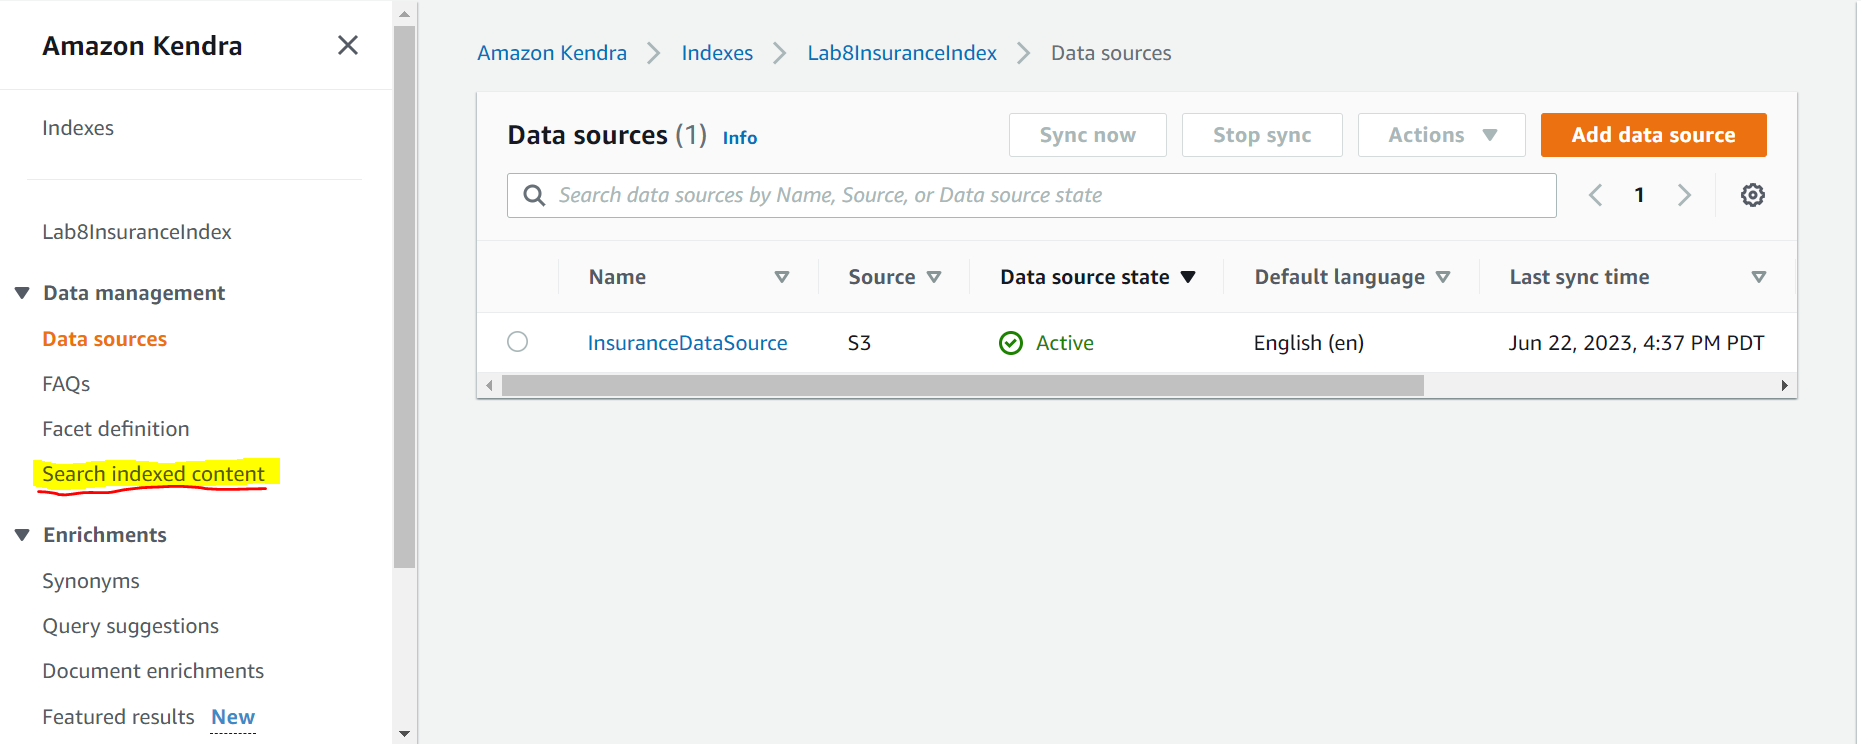

<b> 6.1. Try this query: List of insurances with claim denied due to late filing? <a id="step6_1"></a>

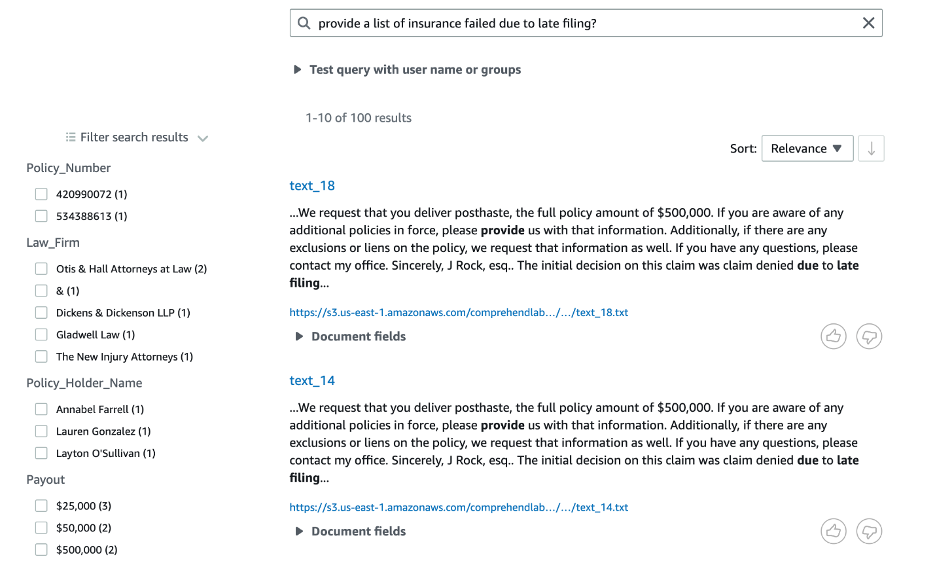

<b>The results above show an answer from the policy type – HOME INSURANCE and brings text_18 and text_14 as the top results.

Choose “Filter search results” on the left. Now you will see all the Entity types and classification values extracted using Comprehend, and for each entity value and classification you will see the number of matching documents.
</b><br />

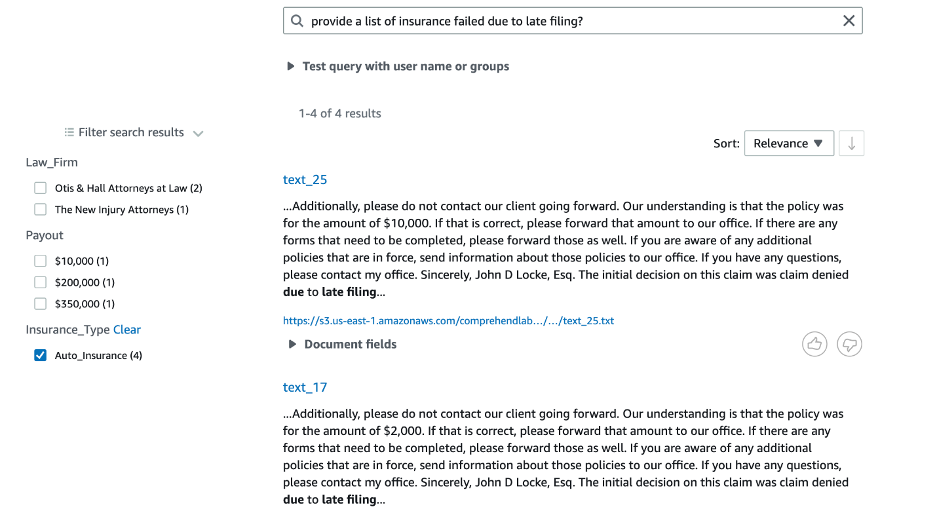

Under `Insurance_Type` choose "Auto_Insurance", and then you will see a response from the files classified as auto insurance. Similarly, you can filter the search results using different entity types and classes. <br />
Note: your results may vary slightly from the results shown in the screenshot.

Try searching with your own queries, and observe how the entities identified by Comprehend allow you quickly to:

* see how your search results are distributed across the categories
* narrow your search by filtering on any of the entity values.



# 7. Clean up <a id="step7"></a>

Delete the Cloudformation stack. Remove the Kendra index and data source to avoid ongoing costs associated with the index. See Kendra pricing. (https://aws.amazon.com/kendra/pricing/)

In [ ]:
# delete Comprehend's custom classfier model endpoint
response = compre_client.delete_endpoint(
    EndpointArn = doc_classifier_endpoint_arn
)

In [ ]:
# delete Comprehend's custom entity recognition model endpoint
response = compre_client.delete_endpoint(
    EndpointArn = custom_entities_endpoint_arn
)

In [ ]:
response = lambda_client.delete_function(
    FunctionName='l8c-kendra-cde-postextraction'
)

In [ ]:
# delete Kendra data source
kendra.delete_data_source(
    Id=data_source_response["Id"],
    IndexId=index_id
)

In [ ]:
# delete Kendra index
kendra.delete_index(
    Id=index_id
)

In [ ]:
# delete policies and roles

# KendraDSRole and policy
iam.detach_role_policy(
    PolicyArn=f"arn:aws:iam::{account_id}:policy/KendraL8CDSPolicy",
    RoleName=kendra_data_source_role
)
iam.delete_policy(
    PolicyArn=f"arn:aws:iam::{account_id}:policy/KendraL8CDSPolicy"
)
iam.delete_role(
    RoleName=kendra_data_source_role
)


#KendraIndexRole and policy
iam.detach_role_policy(
    PolicyArn=f"arn:aws:iam::{account_id}:policy/KendraL8CIndexPolicy",
    RoleName=kendra_index_role
)
iam.delete_policy(
    PolicyArn=f"arn:aws:iam::{account_id}:policy/KendraL8CIndexPolicy"
)
iam.delete_role(
    RoleName=kendra_index_role
)


#Kendra Lambda role and policy
iam.detach_role_policy(
    PolicyArn=f"arn:aws:iam::{account_id}:policy/KendraL8CLambdaPolicy",
    RoleName=kendra_lambda_role
)
iam.delete_policy(
    PolicyArn=f"arn:aws:iam::{account_id}:policy/KendraL8CLambdaPolicy"
)
iam.delete_role(
    RoleName=kendra_lambda_role
)


#SageMaker S3 policy
iam.detach_role_policy(
    PolicyArn=f"arn:aws:iam::{account_id}:policy/SageMakerS3Policy",
    RoleName=kendra_lambda_role
)
iam.delete_policy(
    PolicyArn=f"arn:aws:iam::{account_id}:policy/SageMakerS3Policy"
)

In [ ]:
# Delete the S3 bucket
s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket_name)
bucket.objects.all().delete()
bucket.delete()

# Conclusion <a id="step8"></a>
<br />
In this lab you learned how to use Amazon Kendra CDE and Amazon Comprehend to tag content (insurance documents) with detected entity types and values that characterize the content. You saw how to use the content tags to create valuable metadata you added to your search index to make it possible to facet and filter your search results.
That's it. Congratulations on completing the lab!
